# Analysis and visualization of buildbot built times

This notebook shows a quick analysis of durations of buildbot builds ("buildbot runs"), and the durations of builds of individual packages.

The information on duration of buildbot runs is gathered from the database that buildbot keeps (i.e., the one that makes it possible for it to tell us at http://lsst-buildx.ncsa.illinois.edu:8010/builders/DM_stack/builds/5401 that the build took 7 mins, 49 secs).

The information on how it took to build individual products has been extracted from outputs of lsst_build, e.g., http://lsst-buildx.ncsa.illinois.edu:8010/builders/DM_stack/builds/1216/steps/shell/logs/stdio :
```
lsst_sims: master-g69b085209b+256 (already installed).
           lsst_apps: master-g63be2d204b+9 .................................................................................................................................ok (305.5 sec).
```
etc.

## Preamble

Always execute these cells.

In [1]:
%matplotlib inline
import requests, json, os
import matplotlib.pyplot as plt
import cPickle as pkl
import pandas as pd
import numpy as np
import datetime

# Make pandas plots ggplot-like
pd.options.display.mpl_style = 'default'

## Gather and Prepare

Use buildbot's JSON API to gather build metadata and stdio outputs. Cache them:
* A pickle file, for metadata on builds
* A directory of text file, for stdio outputs

Rerunning this section will intelligently update the caches, avoiding re-downloading already downloaded data.

### Download raw data

In [2]:
! mkdir -p data

In [3]:
##
## Find the buildbot build number of the latest buildbot run
##

url = "http://lsst-buildx.ncsa.illinois.edu:8010/json/builders/DM_stack/builds"
r = requests.get(url=url, params={"select": -1})
maxbuild = r.json()[u'-1'][u'number']
print "Last build: %s" % maxbuild

Last build: 5401


In [4]:
##
## Load and cache the build statistics data.
## Be clever and re-use cached data whenever possible.
##

urlpattern = "http://lsst-buildx.ncsa.illinois.edu:8010/json/builders/DM_stack/builds/%d"

try:
    with open('builds.pkl') as fp:
        builds = pkl.load(fp)
except:
    builds = dict()

for n in xrange(0, maxbuild+1):
    if n in builds:
        continue

    r = requests.get(url=urlpattern % n)
    j = r.json()
    builds[n] = j

# write the new file
with open('builds.pkl.tmp', "w") as fp:
    pkl.dump(builds, fp, -1)
os.rename('builds.pkl.tmp', 'builds.pkl')

In [5]:
##
## Download all stdio logs, store them in data/stdio
##
## Avoid downloading what has already been downloaded.
##

! mkdir -p data/stdio
for build_id, job in builds.iteritems():
    fn = "data/stdio/%d.stdio" % build_id

    if not os.path.exists(fn):
        stream, url = job[u'logs'][0]
        assert(stream == u'stdio')

        r = requests.get(url + '/text')
        r.raise_for_status()

        with open(fn + ".tmp", "w") as fp:
            fp.write(r.text.encode('utf-8'))
        os.rename(fn + ".tmp", fn)


### Preprocessing

In [6]:
##
## Parsing the build times out of stdio buildbot output
##

import re
regexSkip = re.compile(r' *(\w+): (\S+) \((.*)\)')
regexBuild = re.compile(r' *(\w+): (\S+) \.*ok \((.*) sec\)')
BUILD_ID_PREFIX = "# BUILD ID: "

def parse_build_times(lines):
    l0 = next((i for i, l in enumerate(lines) if l.startswith(BUILD_ID_PREFIX)), None)
    if l0 is None:
        return
    build_id = lines[l0][len(BUILD_ID_PREFIX):]
#    l1 = lines.index("# BUILD %s completed." % build_id)
    success_marker = "# BUILD %s completed." % build_id

    # now parse the product build info
    for line in lines[l0+1:]:
        m = regexSkip.match(line)
        if m is not None:
            prod, ver, time = m.group(1), m.group(2), None
        else:
            m = regexBuild.match(line)
            if m is not None:
                prod, ver, time = m.group(1), m.group(2), float(m.group(3)) / 60.
            else:
                return

        yield build_id, prod, ver, time

def load_build_outputs(builds):
    def helper(builds):
        for n in builds:
            with open('data/stdio/%d.stdio' % n) as fp:
                lines = list(line.rstrip('\r\n') for line in fp)

            for entry in parse_build_times(lines):
                yield (n,) + entry

    return np.fromiter(helper(builds),
                   dtype=[('n', int), ('buildId', 'S10'), ('product', 'S40'), ('version', 'S50'), ('buildTime', float)])


In [7]:
#
# A table of [n, buildId, product, version, buildTime (in minutes)
# where n is the buildbot-assigned build number
#
# If the product was not built in this round, then buildTime=NaN

productBuildStats = pd.DataFrame.from_records(load_build_outputs(range(maxbuild+1)))
productBuildStats.to_pickle('productBuildStats.pkl')
productBuildStats[-1:]

,n,buildId,product,version,buildTime
573461,5401,b1057,git,1.8.5.2,NaN


In [8]:
def timediff(t0, t1):
    if t0 is None or t1 is None:
        return 0
    return t1 - t0

def trim_builds_dict(builds):
    for i, (k, j) in enumerate(builds.iteritems()):
        t0, t1 = j[u'times']
        duration = timediff(t0, t1) / 3600
        d0 = datetime.datetime.fromtimestamp(t0) if t0 is not None else None
        d1 = datetime.datetime.fromtimestamp(t1) if t1 is not None else None
        yield (i, {'n': k, 'results': j[u'results'], 't0': d0, 't1': d1, 'duration': duration})

In [9]:
buildbotRunStats = pd.DataFrame.from_dict(dict(trim_builds_dict(builds)), orient='index')
buildbotRunStats.to_pickle('buildbotRunStats.pkl')
buildbotRunStats[-1:]

,duration,t1,results,t0,n
5401,0.130529,2015-04-12 18:07:49.996466,0,2015-04-12 18:00:00.092586,5401


In [10]:
productBuilds = productBuildStats.join(buildbotRunStats, on='n', rsuffix='_df')
productBuilds.to_pickle('productBuilds.pkl')
productBuilds[-1:]

,n,buildId,product,version,buildTime,duration,t1,results,t0,n_df
573461,5401,b1057,git,1.8.5.2,NaN,0.130529,2015-04-12 18:07:49.996466,0,2015-04-12 18:00:00.092586,5401


## Analysis

Load the tables of interest.

In [11]:
productBuildStats = pkl.load(open("productBuildStats.pkl"))
buildbotRunStats = pkl.load(open("buildbotRunStats.pkl"))
productBuilds = pkl.load(open("productBuilds.pkl"))

### Overall build speedups

Let's see the difference in buildbot run durations. This is in many ways the most relevant number, as it gives us the wallclock time we have to wait for buildbot to do a build.

We will split the runs into two groups:
* the runs where at least one product was built (`nonEmptyRuns` in the code below)
* the runs where there were no changes to the source so nothing was built (`emptyRuns` in the code below).

The "before" vs "after" periods are defined as the month of March ("before"), and the month of April ("after"). The cutover to new EUPS happened late evening on March 31st.

In [12]:
nonempty_builds_list = productBuilds.n[~np.isnan(productBuilds.buildTime)].unique()
empty_builds_list = productBuilds.n[~productBuilds.n.isin(nonempty_builds_list)].unique()

nonEmptyRuns = buildbotRunStats[buildbotRunStats.n.isin(nonempty_builds_list)]
emptyRuns =  buildbotRunStats[buildbotRunStats.n.isin(empty_builds_list)]

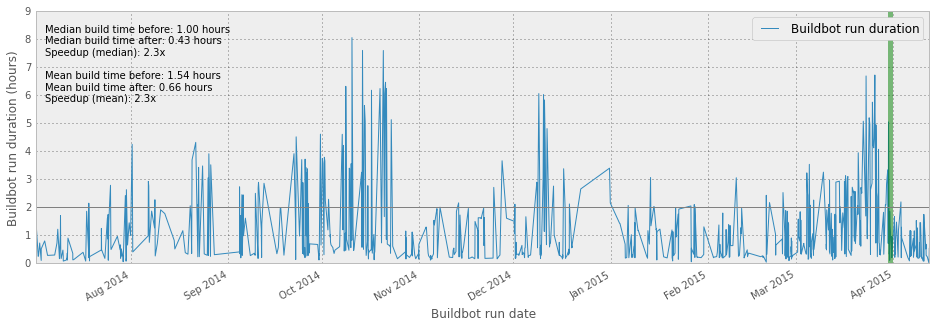

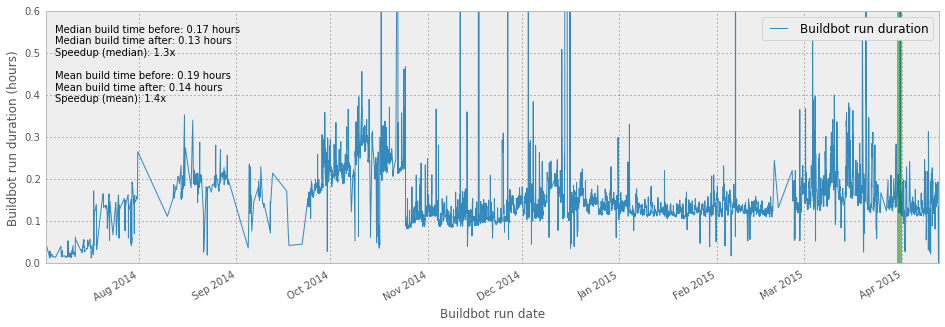

In [14]:
def mkplot(dfx):
    dfx.plot(x='t0', y='duration', kind='line', figsize=(16, 5), legend=False)
    plt.legend(["Buildbot run duration"])

    plt.axvline(datetime.datetime(2015, 3, 31), color='green', linewidth=5, alpha=0.5)
    plt.axhline(2., color='gray')
    plt.xlabel("Buildbot run date")
    plt.ylabel("Buildbot run duration (hours)")

    s1 = dfx[(dfx.t0 > '2015-03-01') & (dfx.t0 < '2015-04-01')].duration
    s2 = dfx[(dfx.t0 > '2015-04-01')].duration

    buildstats = """\
Median build time before: %.2f hours
Median build time after: %.2f hours
Speedup (median): %.1fx

Mean build time before: %.2f hours
Mean build time after: %.2f hours
Speedup (mean): %.1fx
""" % (s1.median(), s2.median(), s1.median() / s2.median(), s1.mean(), s2.mean(), s1.mean() / s2.mean())

    plt.text(0.01, 0.95, buildstats, transform=plt.gca().transAxes, verticalalignment='top')

mkplot(nonEmptyRuns)

mkplot(emptyRuns)
_ = plt.ylim(0, 0.6)

Now, let's look at the distribution of buildbot run durations, before and after.

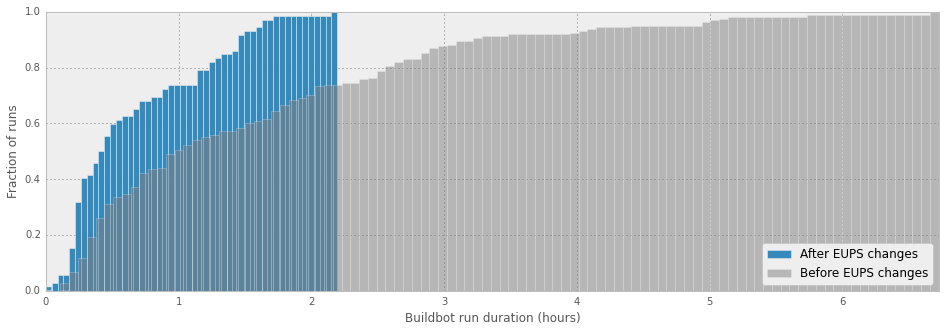

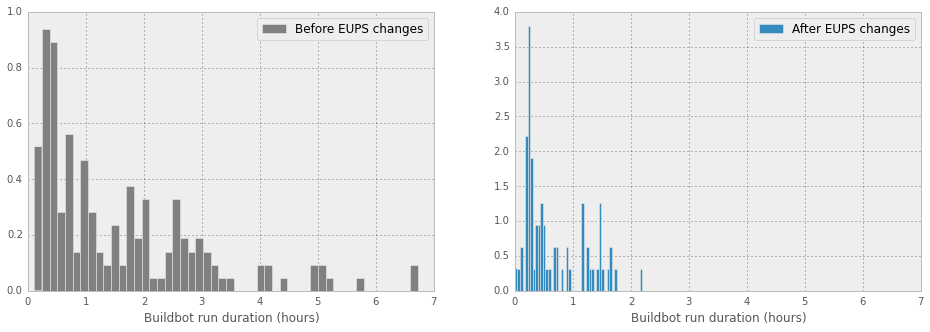

In [15]:
sel_before = (nonEmptyRuns.t0 > '2015-03-01') & (nonEmptyRuns.t0 < '2015-04-01')
sel_after = (nonEmptyRuns.t0 > '2015-04-01')

plt.figure(figsize=(16, 5))
nonEmptyRuns[sel_after].duration.hist(bins=50, cumulative=True, normed=True)
nonEmptyRuns[sel_before].duration.hist(bins=100, cumulative=True, normed=True, alpha=0.5, color='gray')
plt.legend(["After EUPS changes", "Before EUPS changes"], loc='lower right')
plt.xlabel("Buildbot run duration (hours)")
plt.ylabel("Fraction of runs")
plt.margins(0, 0)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
nonEmptyRuns[sel_before].duration.hist(bins=50, normed=True, color='gray')
plt.legend(["Before EUPS changes"])
plt.xlabel("Buildbot run duration (hours)")
lims = plt.xlim()

plt.subplot(1, 2, 2)
nonEmptyRuns[sel_after].duration.hist(bins=50, normed=True)
plt.legend(["After EUPS changes"])
plt.xlabel("Buildbot run duration (hours)")
_ = plt.xlim(lims)

Note how there are no long tails; the worst time-to-do-a-build has been reduced significatnly.

## Speedup of builds of individual products

In [16]:
productBuilds = productBuildStats.join(buildbotRunStats, on='n', rsuffix='_df')
productBuilds[-1:]

,n,buildId,product,version,buildTime,duration,t1,results,t0,n_df
573461,5401,b1057,git,1.8.5.2,NaN,0.130529,2015-04-12 18:07:49.996466,0,2015-04-12 18:00:00.092586,5401


Let's see how much we sped up builds of individual products. Let's pick a few at (semi)random.

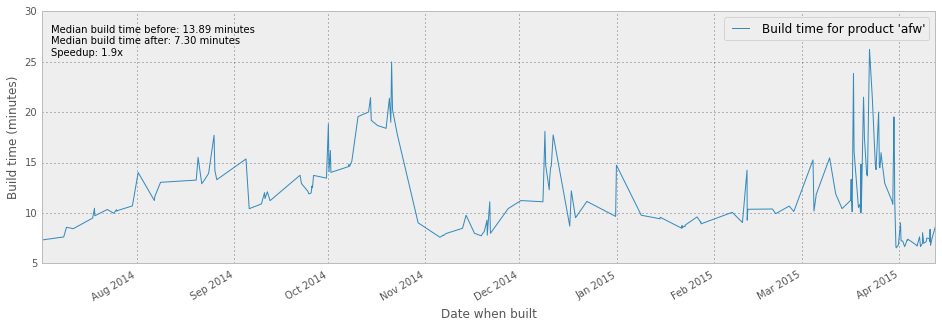

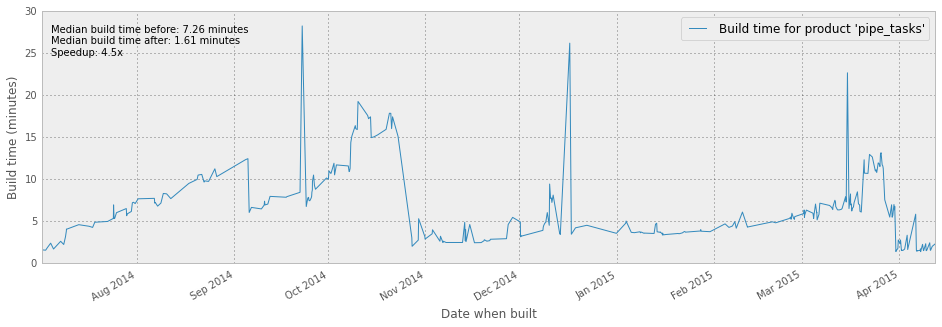

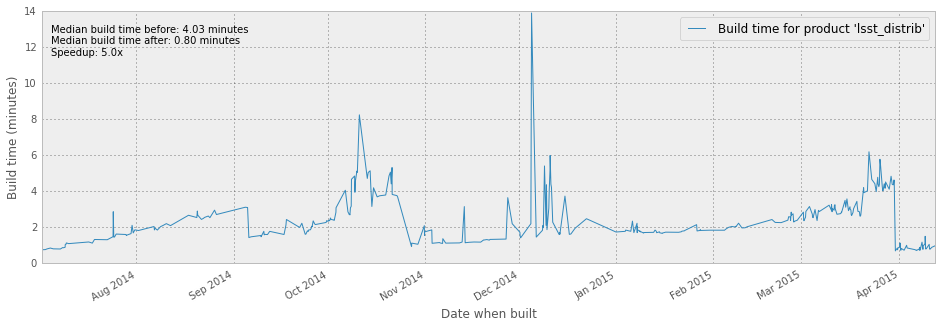

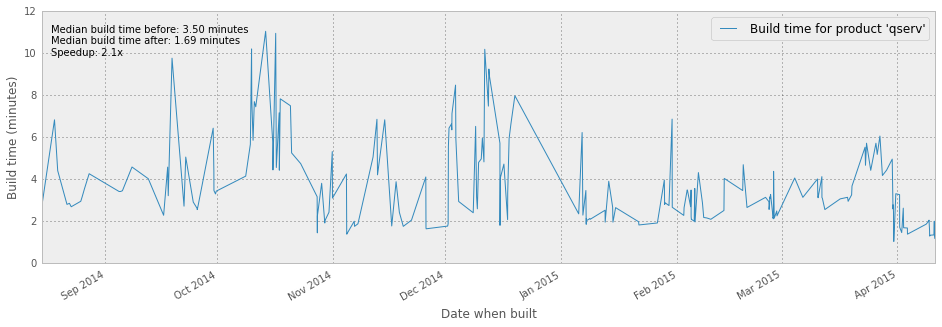

In [17]:
def plot_times_for_product(product, pb):
    """
        Plot buildTime vs. time for `product'
    """
    sel = pb[(pb["product"] == product) & ~np.isnan(pb["buildTime"])]

    sel.plot(x='t0', y='buildTime', kind='line', figsize=(16,5), legend=False)
    plt.ylabel('Build time (minutes)')
    plt.xlabel('Date when built')
    plt.legend(["Build time for product '%s'" % product])

    s1 = sel[(sel.t0 > '2015-03-15') & (sel.t0 < '2015-04-01')]['buildTime']
    s2 = sel[(sel.t0 > '2015-04-01')]['buildTime']
    s1.median(), s2.median()

    buildstats = """\
Median build time before: %.2f minutes
Median build time after: %.2f minutes
Speedup: %.1fx
""" % (s1.median(), s2.median(), s1.median() / s2.median())

    plt.text(0.01, 0.95, buildstats, transform=plt.gca().transAxes, verticalalignment='top')

for prod in ["afw", "pipe_tasks", "lsst_distrib", "qserv"]:
    plot_times_for_product(prod, productBuilds)

Now, the speedup statistics for all of them:

In [18]:
sel = productBuilds[~np.isnan(productBuilds["buildTime"])]

bt = sel[["product", "buildTime"]]
sg1 = bt[(sel.t0 > '2015-03-15') & (sel.t0 < '2015-04-01')].groupby("product").aggregate(np.median)
sg2 = bt[(sel.t0 > '2015-04-01')].groupby("product").aggregate(np.median)

res = (sg1 / sg2).rename(columns={'buildTime': 'speedup'}).dropna().sort("speedup", ascending=False).join(sg2)

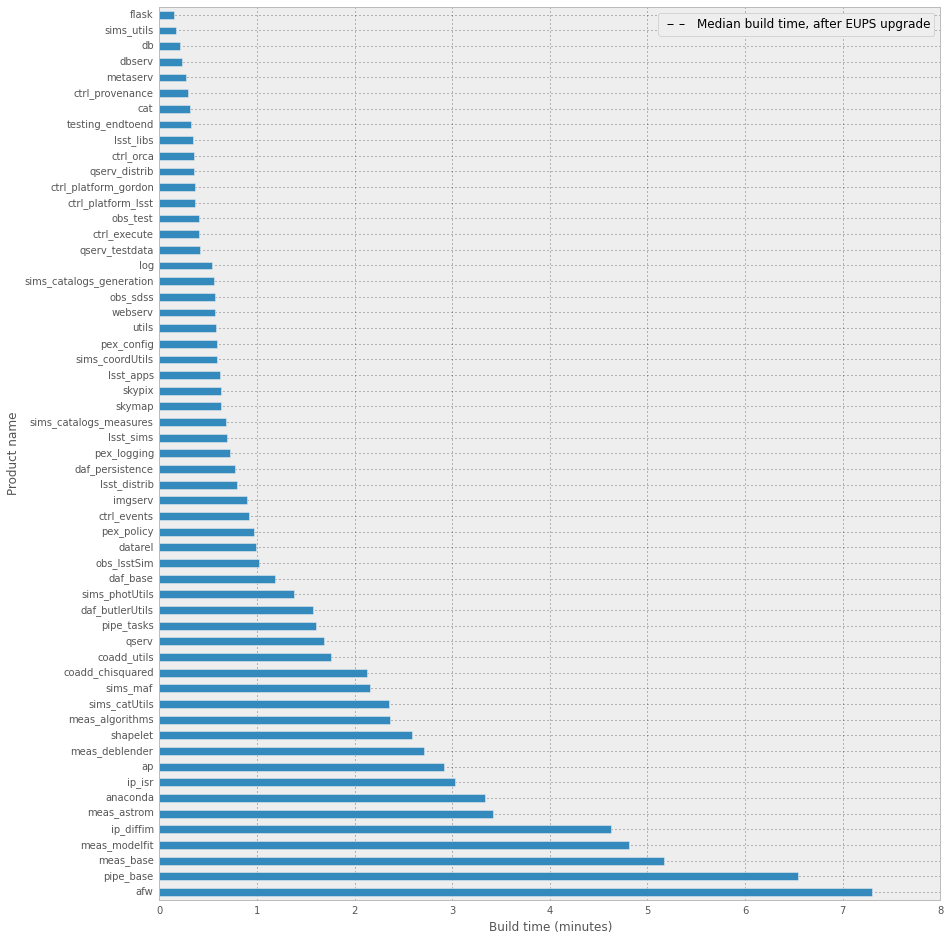

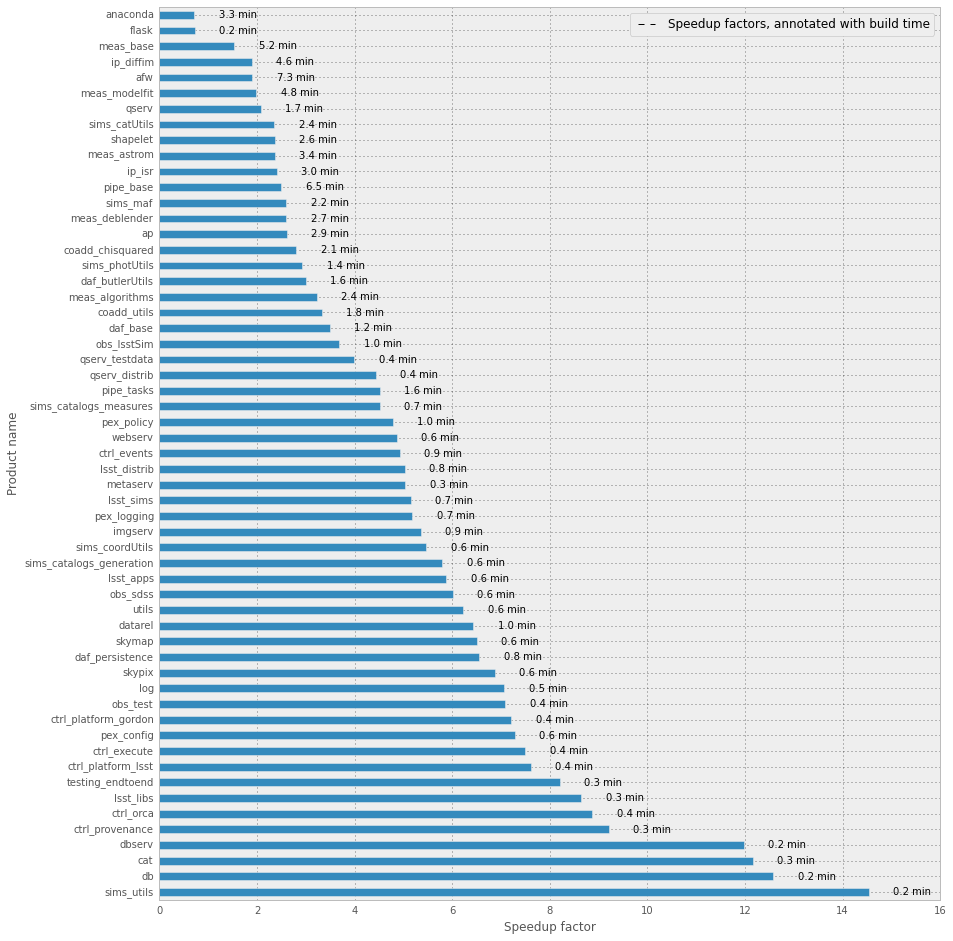

In [22]:
# Visualize build times
sg2.sort("buildTime", ascending=False).plot(figsize=(14, 16), kind='barh')
plt.legend(["Median build time, after EUPS upgrade"])
plt.ylabel("Product name")
plt.xlabel("Build time (minutes)")

# Visualize speedups
res[["speedup"]].plot(figsize=(14, 16), kind='barh')
plt.legend(["Speedup factors, annotated with build time"])
plt.ylabel("Product name")
plt.xlabel("Speedup factor")

#add the numbers to the side of each bar
for k, (_, row) in enumerate(res.iterrows()):
    plt.annotate("%.1f min" % row.buildTime, xy=(row.speedup + 0.5, k), va='center')

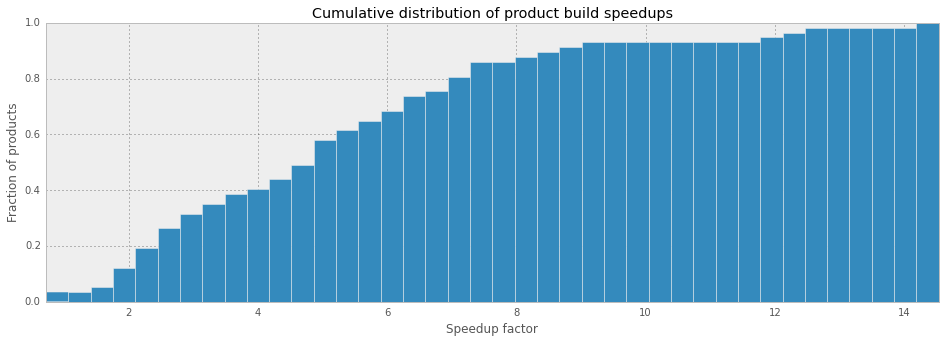

In [20]:
# Visualize distribution of speedups
res[["speedup"]].hist(bins=40, cumulative=True, normed=True, figsize=(16,5))
plt.xlabel("Speedup factor")
plt.ylabel("Fraction of products")
plt.title("Cumulative distribution of product build speedups")
plt.margins(0, 0)

## TODO

An interesting quantity to visualize would be the time-to-build the stack starting at a specific product (i.e., "how long do I need to wait for the stack to be built if I make a change to 'afw'). We'll need dependency information for this, probably would need to pull it from versiondb...